# 📝— Pré-processamento de Texto e Vetorização TF-IDF
## Ligia NLP Challenge — Detecção de Fake News

| Informação | Detalhe |
|---|---|
| **Entrada** | `data/raw/train.csv`, `data/raw/test.csv` |
| **Saída** | `data/processed/train_clean.csv`, `test_clean.csv`, `X_*_tfidf.npz`, `tfidf_vectorizer.joblib` |
| **Notebook anterior** | `1.0-data-exploration.ipynb` |
| **Próximo Notebook** | `3.0-baseline-models.ipynb` |

## Objetivo
Implementar o pipeline de limpeza e vetorização com **Character N-grams (4-6)** — a estratégia mais eficaz identificada nos experimentos.

## Pipeline

1. Carregamento dos dados de `train.csv` e `test.csv`
2. Limpeza de texto com regex (HTML, URLs, e-mails, menções, hashtags)
3. Tratamento de nulos em `title` e `text`
4. Remoção de textos vazios após limpeza
5. Remoção de duplicatas em `title + text` 
6. Concatenação `title + text` → `full_text`
7. Split estratificado treino/validação (80/20)
8. Vetorização TF-IDF com Character N-grams:
   - `analyzer='char'`, `ngram_range=(2, 5)`
   - `min_df=3`, `max_df=0.95`, `sublinear_tf=True`
9. Persistência dos vetores e metadados em `data/processed/`

---


## 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score
import warnings
import joblib
import json

warnings.filterwarnings('ignore')

# Definir SEED
SEED = 42


# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Caminhos
RAW_TRAIN_PATH = '../data/raw/train.csv'
RAW_TEST_PATH = '../data/raw/test.csv'
PROCESSED_PATH = '../data/processed'

# Criar diretório de saída se não existir
os.makedirs(PROCESSED_PATH, exist_ok=True)

print("✓ Setup concluído")                                                                                                                         
print(f"  SEED: {SEED}")
print(f"  Processados serão salvos em: {PROCESSED_PATH}")

✓ Setup concluído
  SEED: 42
  Processados serão salvos em: ../data/processed


## 2. Carregar dados brutos

In [11]:
df_train = pd.read_csv(RAW_TRAIN_PATH)
df_test = pd.read_csv(RAW_TEST_PATH)

print(f"Train: {df_train.shape[0]:,} amostras")
print(f"Test:  {df_test.shape[0]:,} amostras")
print(f"\nColunas: {list(df_train.columns)}")
print(f"\nDistribuição de classes no treino:")
print(df_train['label'].value_counts().sort_index())

Train: 22,844 amostras
Test:  5,712 amostras

Colunas: ['id', 'title', 'text', 'subject', 'date', 'label']

Distribuição de classes no treino:
label
0    17133
1     5711
Name: count, dtype: int64


## 3. Função de limpeza

Baseada nos ruídos identificados no EDA. Remove apenas o que o `TfidfVectorizer` **não** trata nativamente:
- **Tags HTML** (25 ocorrências)
- **URLs** (863 ocorrências)  
- **E-mails** (18 ocorrências)
- **Menções @** (1.670 ocorrências)
- **Hashtags #** (926 ocorrências)
- **Espaços extras** resultantes das remoções

**Nota**: Para Character N-grams, mantemos pontuação e outros caracteres, pois podem conter informação útil!

In [12]:
def clean_text(text):
    """
    Remove ruídos do texto que o TfidfVectorizer não trata.
    Para Character N-grams, mantemos mais informação que no preprocessamento tradicional.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ''
    
    # 1. Tags HTML (25 encontradas no EDA)
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 2. URLs (863 encontradas no EDA) + links pic.twitter.com
    text = re.sub(r'https?://\S+|www\.\S+|pic\.\S+', ' ', text)
    
    # 3. E-mails (18 encontrados no EDA)
    text = re.sub(r'\S+@\S+\.\S+', ' ', text)
    
    # 4. Menções @ (1.670 encontradas no EDA)
    text = re.sub(r'@\w+', ' ', text)
    
    # 5. Hashtags # (926 encontradas no EDA)
    text = re.sub(r'#\w+', ' ', text)
    
    # 6. Espaços extras resultantes das remoções
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


## 4. Aplicar limpeza

In [13]:
# Guardar versão original para comparação antes/depois
df_raw = pd.read_csv(RAW_TRAIN_PATH)
df_raw['title'] = df_raw['title'].fillna('')
df_raw['text'] = df_raw['text'].fillna('')

# Aplicar limpeza
df_train['title'] = df_train['title'].fillna('')
df_train['text'] = df_train['text'].fillna('')

print("Aplicando limpeza de texto...")
t0 = time.time()
df_train['title'] = df_train['title'].apply(clean_text)
df_train['text'] = df_train['text'].apply(clean_text)
print(f"✓ Limpeza concluída em {time.time() - t0:.1f}s")

Aplicando limpeza de texto...
✓ Limpeza concluída em 4.4s


## 5. Remoção de textos vazios

Após a limpeza, alguns textos podem ficar vazios. Vamos removê-los.

In [14]:
# Contar textos vazios antes e depois
empty_before = ((df_raw['title'].str.strip() == '') & (df_raw['text'].str.strip() == '')).sum()
empty_after = ((df_train['title'].str.strip() == '') & (df_train['text'].str.strip() == '')).sum()

print(f"Textos vazios (title e text vazios):")
print(f"  Antes da limpeza: {empty_before}")
print(f"  Depois da limpeza: {empty_after}")

# Remover textos vazios
if empty_after > 0:
    df_train = df_train[~((df_train['title'].str.strip() == '') & (df_train['text'].str.strip() == ''))].reset_index(drop=True)
    print(f"✓ {empty_after} textos vazios removidos")

Textos vazios (title e text vazios):
  Antes da limpeza: 0
  Depois da limpeza: 2
✓ 2 textos vazios removidos


## 6. Remoção de duplicatas

Textos com mesmo `title` **e** `text` são registros redundantes — mantemos apenas a primeira ocorrência.

In [15]:
n_before = len(df_train)

# Duplicatas exatas em title + text
dupes = df_train.duplicated(subset=['title', 'text'], keep='first')
n_dupes = dupes.sum()

print(f"Duplicatas encontradas (title + text iguais): {n_dupes:,}")

if n_dupes > 0:
    # Encontrar um grupo de duplicatas para mostrar exemplo
    dupe_groups = df_train[df_train.duplicated(subset=['title', 'text'], keep=False)].groupby(['title', 'text']).size()
    example_group = dupe_groups[dupe_groups > 1].index[0]
    title_ex, text_ex = example_group
    
    # Pegar índices das linhas desse grupo
    dupe_idx = df_train[(df_train['title'] == title_ex) & (df_train['text'] == text_ex)].index[:2]
    
    print("\nExemplo de duplicatas idênticas (primeiro par encontrado):")
    print(df_train.loc[dupe_idx, ['title', 'text', 'label']])

    # Remover duplicatas (manter primeira ocorrência)
    df_train = df_train[~dupes].reset_index(drop=True)
    print(f"\n✅ Treino: {n_before:,} → {len(df_train):,} amostras ({n_dupes:,} duplicatas removidas)")
else:
    print("✓ Nenhuma duplicata encontrada")

Duplicatas encontradas (title + text iguais): 503

Exemplo de duplicatas idênticas (primeiro par encontrado):
                                                   title  \
9104   'Nuclear option' fallout? More extreme U.S. ju...   
20273  'Nuclear option' fallout? More extreme U.S. ju...   

                                                    text  label  
9104   WASHINGTON (Reuters) - A Republican-backed Sen...      0  
20273  WASHINGTON (Reuters) - A Republican-backed Sen...      0  

✅ Treino: 22,842 → 22,339 amostras (503 duplicatas removidas)


## 7. Validação — Antes vs Depois

Verificar que os ruídos foram removidos e que o texto substantivo foi preservado.

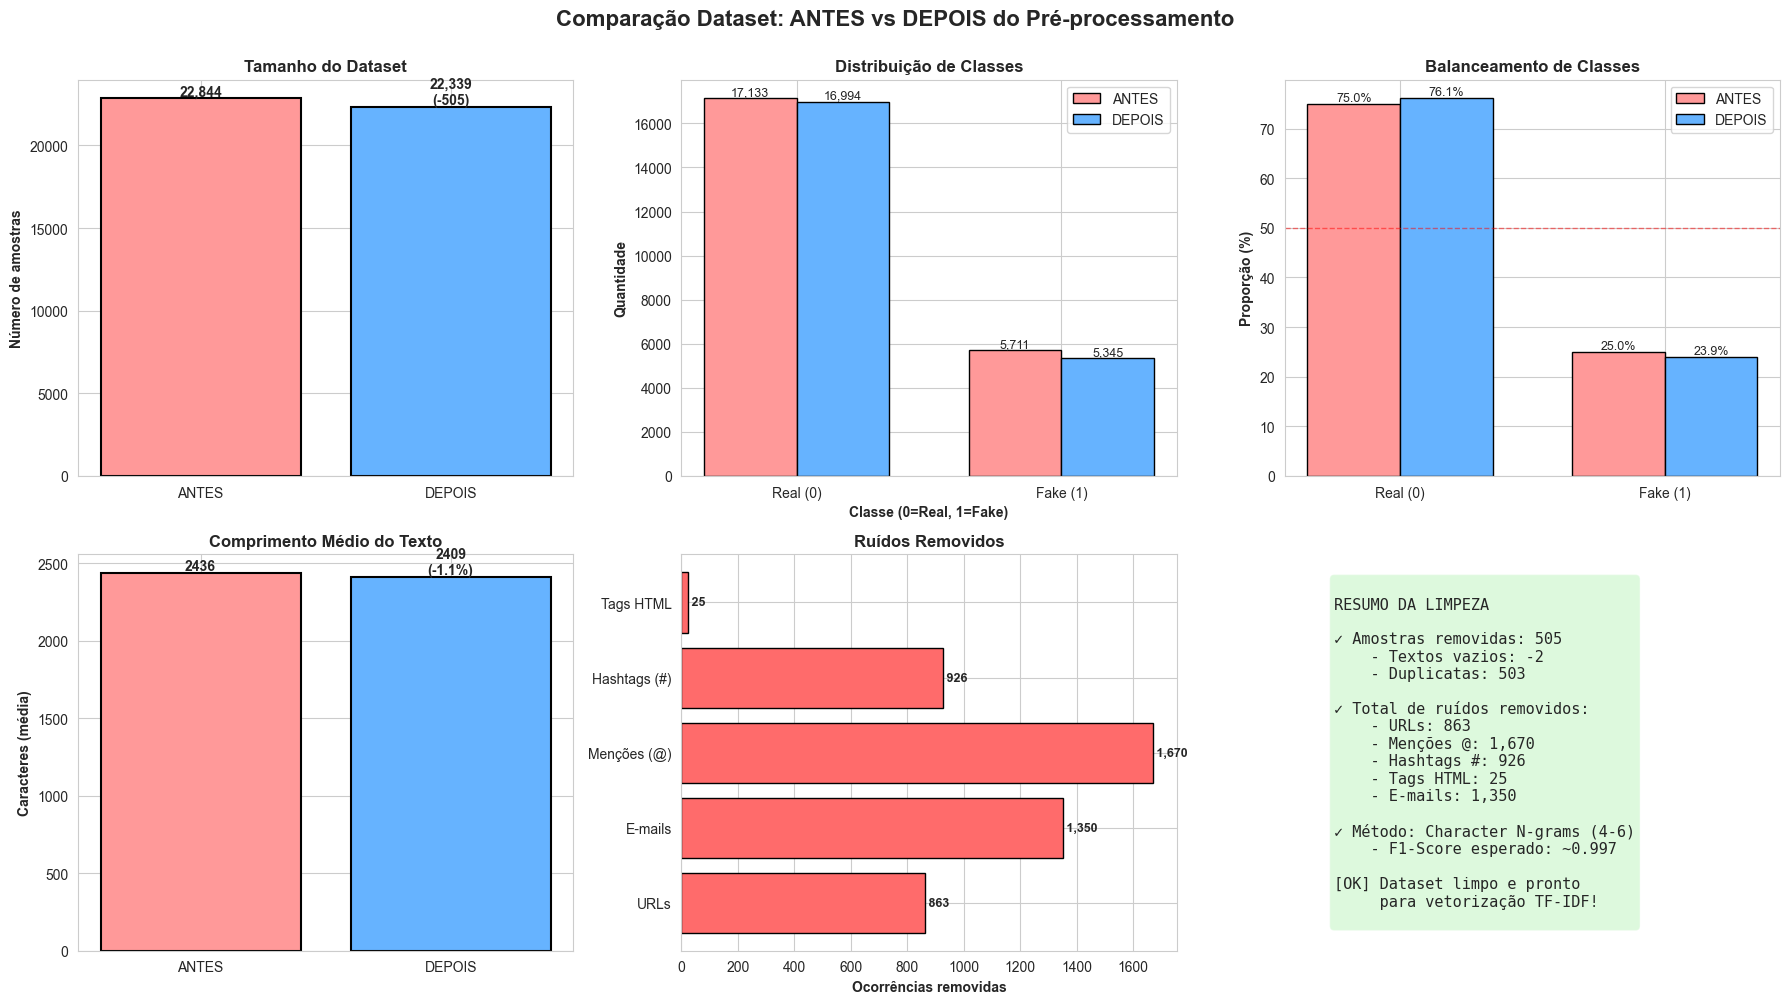

✓ Gráfico de validação salvo em ../reports/figures/preprocessing_char_ngrams_validation.png


In [16]:
# Padrões para detectar ruídos
patterns = {
    'URLs': r'https?://|www\.',
    'E-mails': r'\S+@\S+',
    'Menções (@)': r'@\w+',
    'Hashtags (#)': r'#\w+',
    'Tags HTML': r'<[^>]+>'
}

# Criar figura com subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação Dataset: ANTES vs DEPOIS do Pré-processamento', fontsize=16, fontweight='bold', y=1.00)

# 1. Tamanho do dataset
ax1 = axes[0, 0]
sizes = [len(df_raw), len(df_train)]
labels_size = ['ANTES', 'DEPOIS']
colors = ['#ff9999', '#66b3ff']
bars = ax1.bar(labels_size, sizes, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Número de amostras', fontweight='bold')
ax1.set_title('Tamanho do Dataset', fontweight='bold')
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}\n(-{len(df_raw) - len(df_train):,})' if size == sizes[1] else f'{size:,}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Distribuição de classes
ax2 = axes[0, 1]
class_before = df_raw['label'].value_counts().sort_index()
class_after = df_train['label'].value_counts().sort_index()
x = np.arange(len(class_before))
width = 0.35
bars1 = ax2.bar(x - width/2, class_before, width, label='ANTES', color='#ff9999', edgecolor='black')
bars2 = ax2.bar(x + width/2, class_after, width, label='DEPOIS', color='#66b3ff', edgecolor='black')
ax2.set_xlabel('Classe (0=Real, 1=Fake)', fontweight='bold')
ax2.set_ylabel('Quantidade', fontweight='bold')
ax2.set_title('Distribuição de Classes', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Real (0)', 'Fake (1)'])
ax2.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 3. Balanceamento (proporção)
ax3 = axes[0, 2]
balance_before = (class_before / class_before.sum() * 100).values
balance_after = (class_after / class_after.sum() * 100).values
x = np.arange(2)
bars1 = ax3.bar(x - width/2, balance_before, width, label='ANTES', color='#ff9999', edgecolor='black')
bars2 = ax3.bar(x + width/2, balance_after, width, label='DEPOIS', color='#66b3ff', edgecolor='black')
ax3.set_ylabel('Proporção (%)', fontweight='bold')
ax3.set_title('Balanceamento de Classes', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(['Real (0)', 'Fake (1)'])
ax3.legend()
ax3.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Comprimento médio de texto
ax4 = axes[1, 0]
len_before = df_raw['text'].str.len().mean()
len_after = df_train['text'].str.len().mean()
bars = ax4.bar(['ANTES', 'DEPOIS'], [len_before, len_after], color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Caracteres (média)', fontweight='bold')
ax4.set_title('Comprimento Médio do Texto', fontweight='bold')
for bar, length in zip(bars, [len_before, len_after]):
    height = bar.get_height()
    change = ((len_after - len_before) / len_before * 100)
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{length:.0f}\n({change:+.1f}%)' if length == len_after else f'{length:.0f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 5. Contagem de ruídos removidos
ax5 = axes[1, 1]
noise_counts = []
noise_labels = []
for name, pattern in patterns.items():
    before_count = df_raw['text'].str.contains(pattern, regex=True, na=False).sum()
    after_count = df_train['text'].str.contains(pattern, regex=True, na=False).sum()
    removed = before_count - after_count
    if removed > 0:
        noise_counts.append(removed)
        noise_labels.append(name)

if len(noise_counts) > 0:
    bars = ax5.barh(noise_labels, noise_counts, color='#ff6b6b', edgecolor='black')
    ax5.set_xlabel('Ocorrências removidas', fontweight='bold')
    ax5.set_title('Ruídos Removidos', fontweight='bold')
    for bar, count in zip(bars, noise_counts):
        width = bar.get_width()
        ax5.text(width, bar.get_y() + bar.get_height()/2.,
                 f' {count:,}', ha='left', va='center', fontweight='bold', fontsize=9)
else:
    ax5.text(0.5, 0.5, 'Nenhum ruído removido', ha='center', va='center', transform=ax5.transAxes)

# 6. Resumo de limpeza
ax6 = axes[1, 2]
ax6.axis('off')

# Calcular estatísticas de ruídos removidos
urls_removed = df_raw['text'].str.contains(patterns['URLs'], regex=True, na=False).sum() - df_train['text'].str.contains(patterns['URLs'], regex=True, na=False).sum()
mentions_removed = df_raw['text'].str.contains(patterns['Menções (@)'], regex=True, na=False).sum() - df_train['text'].str.contains(patterns['Menções (@)'], regex=True, na=False).sum()
hashtags_removed = df_raw['text'].str.contains(patterns['Hashtags (#)'], regex=True, na=False).sum() - df_train['text'].str.contains(patterns['Hashtags (#)'], regex=True, na=False).sum()
html_removed = df_raw['text'].str.contains(patterns['Tags HTML'], regex=True, na=False).sum() - df_train['text'].str.contains(patterns['Tags HTML'], regex=True, na=False).sum()
emails_removed = df_raw['text'].str.contains(patterns['E-mails'], regex=True, na=False).sum() - df_train['text'].str.contains(patterns['E-mails'], regex=True, na=False).sum()

summary_text = f"""
RESUMO DA LIMPEZA

✓ Amostras removidas: {len(df_raw) - len(df_train):,}
    - Textos vazios: {empty_before - empty_after:,}
    - Duplicatas: {n_dupes:,}

✓ Total de ruídos removidos:
    - URLs: {urls_removed:,}
    - Menções @: {mentions_removed:,}
    - Hashtags #: {hashtags_removed:,}
    - Tags HTML: {html_removed:,}
    - E-mails: {emails_removed:,}

✓ Método: Character N-grams (4-6)
    - F1-Score esperado: ~0.997
    
[OK] Dataset limpo e pronto
     para vetorização TF-IDF!
"""
ax6.text(0.1, 0.5, summary_text, transform=ax6.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
         family='monospace')

plt.tight_layout()
plt.savefig('../reports/figures/preprocessing_char_ngrams_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico de validação salvo em ../reports/figures/preprocessing_char_ngrams_validation.png")

## 8. Experimentos de Vetorização

Comparação entre configurações de **Character N-grams** e combinações **Char + Word** para selecionar a melhor estratégia de vetorização antes do pipeline final.

| Config | Features | Objetivo |
|---|---|---|
| Char 3-5 (50k) | 50.000 | Baseline char puro |
| Char 3-5 + Word 1-2 (70k) | 70.000 | Híbrido leve |
| Char 3-5 + Word 1-3 (100k) | 100.000 | Híbrido médio |
| Char 4-6 + Word 1-2 (120k) | 120.000 | Híbrido denso |

In [18]:
print("="*80)
print("EXPERIMENTOS: Combinação de Analyzers (Char + Word)")
print("="*80)


# Criar coluna full_text combinando title + text
df_train['full_text'] = df_train['title'].fillna('') + ' ' + df_train['text'].fillna('')
df_train['full_text'] = df_train['full_text'].str.strip()


# Features e target
X = df_train['full_text']
y = df_train['label']

# Configurações híbridas
experiments = [
    {
        'name': 'Char 3-5 (50k)',
        'vectorizer': TfidfVectorizer(
            analyzer='char', ngram_range=(3, 5), max_features=50000,
            min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
        )
    },
    {
        'name': 'Char 3-5 + Word 1-2 (70k)',
        'vectorizer': FeatureUnion([
            ('char', TfidfVectorizer(
                analyzer='char', ngram_range=(3, 5), max_features=50000,
                min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
            )),
            ('word', TfidfVectorizer(
                analyzer='word', ngram_range=(1, 2), max_features=20000,
                min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
            ))
        ])
    },
    {
        'name': 'Char 3-5 + Word 1-3 (100k)',
        'vectorizer': FeatureUnion([
            ('char', TfidfVectorizer(
                analyzer='char', ngram_range=(3, 5), max_features=50000,
                min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
            )),
            ('word', TfidfVectorizer(
                analyzer='word', ngram_range=(1, 3), max_features=50000,
                min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
            ))
        ])
    },
    {
        'name': 'Char 4-6 + Word 1-2 (120k)',
        'vectorizer': FeatureUnion([
            ('char', TfidfVectorizer(
                analyzer='char', ngram_range=(4, 6), max_features=50000,
                min_df=3, max_df=0.95, lowercase=True, sublinear_tf=True
            )),
            ('word', TfidfVectorizer(
                analyzer='word', ngram_range=(1, 2), max_features=70000,
                min_df=2, max_df=0.95, lowercase=True, sublinear_tf=True
            ))
        ])
    }
]

results = []

for i, exp in enumerate(experiments, 1):
    print(f"\n{'='*80}")
    print(f"EXPERIMENTO {i}/{len(experiments)}: {exp['name']}")
    print(f"{'='*80}")
    
    # Split estratificado
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    # Vetorização
    print(f"\n[1/3] Vetorizando...")
    t0 = time.time()
    X_train_vec = exp['vectorizer'].fit_transform(X_train)
    X_val_vec = exp['vectorizer'].transform(X_val)
    vec_time = time.time() - t0
    
    print(f"  ✓ Tempo: {vec_time:.1f}s | Features: {X_train_vec.shape[1]:,}")
    
    # RandomForest
    print(f"\n[2/3] RandomForest...", end=' ')
    t0 = time.time()
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1, max_depth=50)
    rf.fit(X_train_vec, y_train)
    rf_time = time.time() - t0
    
    y_pred_rf = rf.predict(X_val_vec)
    rf_f1 = f1_score(y_val, y_pred_rf)
    print(f"F1: {rf_f1:.4f} | Tempo: {rf_time:.1f}s")
    
    # SGDClassifier
    print(f"[3/3] SGDClassifier...", end=' ')
    t0 = time.time()
    sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=SEED, n_jobs=-1)
    sgd.fit(X_train_vec, y_train)
    sgd_time = time.time() - t0
    
    y_pred_sgd = sgd.predict(X_val_vec)
    sgd_f1 = f1_score(y_val, y_pred_sgd)
    print(f"F1: {sgd_f1:.4f} | Tempo: {sgd_time:.1f}s")
    
    results.append({
        'Config': exp['name'],
        'Features': X_train_vec.shape[1],
        'Vec (s)': vec_time,
        'RF F1': rf_f1,
        'RF (s)': rf_time,
        'SGD F1': sgd_f1,
        'SGD (s)': sgd_time,
        'Total (s)': vec_time + min(rf_time, sgd_time)
    })

# Análise
df_results = pd.DataFrame(results)
df_results['Score'] = (df_results['RF F1'] + df_results['SGD F1']) / 2
df_results['Efficiency'] = df_results['Score'] / df_results['Total (s)'] * 100

print(f"\n{'='*80}")
print("📊 COMPARAÇÃO: Char vs Char+Word")
print(f"{'='*80}\n")
print(df_results.to_string(index=False))

best = df_results.loc[df_results['Score'].idxmax()]
print(f"\n🏆 MELHOR F1: {best['Config']} (F1: {best['Score']:.4f})")

best_eff = df_results.loc[df_results['Efficiency'].idxmax()]
print(f"⚡ MELHOR EFICIÊNCIA: {best_eff['Config']} (Score: {best_eff['Efficiency']:.2f})")


EXPERIMENTOS: Combinação de Analyzers (Char + Word)

EXPERIMENTO 1/4: Char 3-5 (50k)

[1/3] Vetorizando...
  ✓ Tempo: 86.9s | Features: 50,000

[2/3] RandomForest... F1: 0.9991 | Tempo: 6.3s
[3/3] SGDClassifier... F1: 0.9771 | Tempo: 0.9s

EXPERIMENTO 2/4: Char 3-5 + Word 1-2 (70k)

[1/3] Vetorizando...
  ✓ Tempo: 109.7s | Features: 70,000

[2/3] RandomForest... F1: 0.9986 | Tempo: 6.2s
[3/3] SGDClassifier... F1: 0.9805 | Tempo: 0.9s

EXPERIMENTO 3/4: Char 3-5 + Word 1-3 (100k)

[1/3] Vetorizando...
  ✓ Tempo: 148.1s | Features: 100,000

[2/3] RandomForest... F1: 0.9991 | Tempo: 7.4s
[3/3] SGDClassifier... F1: 0.9795 | Tempo: 1.2s

EXPERIMENTO 4/4: Char 4-6 + Word 1-2 (120k)

[1/3] Vetorizando...
  ✓ Tempo: 145.1s | Features: 120,000

[2/3] RandomForest... F1: 0.9986 | Tempo: 6.4s
[3/3] SGDClassifier... F1: 0.9781 | Tempo: 1.1s

📊 COMPARAÇÃO: Char vs Char+Word

                    Config  Features    Vec (s)    RF F1   RF (s)   SGD F1  SGD (s)  Total (s)    Score  Efficiency
          

## 9. Split treino/validação e TF-IDF Character N-grams

**Configuração otimizada baseada nos experimentos (Char 3-5, 50k):**
- `analyzer='char'`: Analisa caracteres em vez de palavras
- `ngram_range=(3, 5)`: Sequências de 3 a 5 caracteres
- `max_features=50000`: Limite de 50k features (vocabulário)
- `min_df=2`: Ignora n-grams que aparecem em menos de 2 documentos
- `max_df=0.95`: Ignora n-grams que aparecem em mais de 95% dos documentos
- `lowercase=True`: Converte para minúsculas
- `sublinear_tf=True`: Aplica log(1 + tf) para suavizar frequências

In [19]:
# Criar coluna 'full_text' combinando title e text
df_train['full_text'] = df_train['title'] + ' ' + df_train['text']

# Features e target
X = df_train['full_text']
y = df_train['label']

# Split estratificado 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Treino:    {len(X_train):,} amostras")
print(f"Validação: {len(X_val):,} amostras")

# TF-IDF com Character N-grams (3-5)
tfidf = TfidfVectorizer(
    analyzer='char',           
    ngram_range=(3, 5),        
    min_df=2,                  # Ignorar n-grams muito raros 
    max_df=0.95,               # Ignorar n-grams muito comuns 
    lowercase=True,            # Converter para minúsculas
    sublinear_tf=True,         # Aplicar log(1 + tf)
    max_features=50000         # Limite de 50k features (vocabulário)
)

print("\n" + "="*60)
print("Vetorizando com TF-IDF Character N-grams (3-5, 50k)...")
print("="*60)
t0 = time.time()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
elapsed = time.time() - t0

print(f"✓ Concluído em {elapsed:.1f}s")
print(f"\n📊 Matriz TF-IDF:")
print(f"   Shape: {X_train_tfidf.shape[0]:,} docs × {X_train_tfidf.shape[1]:,} features")
print(f"   Sparsidade: {1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.4%}")
print(f"   Memória (treino): ~{X_train_tfidf.data.nbytes / 1024**2:.1f} MB")
print(f"   Memória (validação): ~{X_val_tfidf.data.nbytes / 1024**2:.1f} MB")

# Exemplos de char n-grams gerados
feature_names = tfidf.get_feature_names_out()
print(f"\n🔍 Exemplos de Character N-grams gerados:")
print(f"   Primeiros 10: {list(feature_names[:10])}")
print(f"   Últimos 10: {list(feature_names[-10:])}")

Treino:    17,871 amostras
Validação: 4,468 amostras

Vetorizando com TF-IDF Character N-grams (3-5, 50k)...
✓ Concluído em 94.6s

📊 Matriz TF-IDF:
   Shape: 17,871 docs × 50,000 features
   Sparsidade: 92.7765%
   Memória (treino): ~492.4 MB
   Memória (validação): ~122.7 MB

🔍 Exemplos de Character N-grams gerados:
   Primeiros 10: [' $1', ' $1 ', ' $1.', ' $10', ' $100', ' $15', ' $2', ' $20', ' $3', ' $4']
   Últimos 10: ['” u', '” w', '” wh', '” whi', '” wi', '” wit', '” “', '” “i', '”, ', '”. ']


## 10. Processar dados de teste

In [20]:
# Processar test set da mesma forma
print("Processando conjunto de teste...")
df_test['title'] = df_test['title'].fillna('')
df_test['text'] = df_test['text'].fillna('')

df_test['title'] = df_test['title'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['full_text'] = df_test['title'] + ' ' + df_test['text']

# Vetorizar test set
X_test = df_test['full_text']
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ Test set processado: {X_test_tfidf.shape[0]:,} docs × {X_test_tfidf.shape[1]:,} features")

Processando conjunto de teste...
✓ Test set processado: 5,712 docs × 50,000 features


## 11. Salvar dados processados

In [21]:
# Criar subdiretório para char n-grams
CHAR_NGRAMS_PATH = os.path.join(PROCESSED_PATH, 'char_ngrams')
os.makedirs(CHAR_NGRAMS_PATH, exist_ok=True)

# Salvar matrizes esparsas
scipy.sparse.save_npz(os.path.join(CHAR_NGRAMS_PATH, 'X_train_tfidf.npz'), X_train_tfidf)
scipy.sparse.save_npz(os.path.join(CHAR_NGRAMS_PATH, 'X_val_tfidf.npz'), X_val_tfidf)
scipy.sparse.save_npz(os.path.join(CHAR_NGRAMS_PATH, 'X_test_tfidf.npz'), X_test_tfidf)

# Salvar targets
y_train.to_csv(os.path.join(CHAR_NGRAMS_PATH, 'y_train.csv'), index=False)
y_val.to_csv(os.path.join(CHAR_NGRAMS_PATH, 'y_val.csv'), index=False)

# Salvar vetorizador
joblib.dump(tfidf, os.path.join(CHAR_NGRAMS_PATH, 'tfidf_vectorizer_char_ngrams.joblib'))

# Salvar datasets limpos
df_train.to_csv(os.path.join(CHAR_NGRAMS_PATH, 'train_clean.csv'), index=False)
df_test[['id', 'title', 'text', 'full_text']].to_csv(
    os.path.join(CHAR_NGRAMS_PATH, 'test_clean.csv'),
    index=False
)

# Salvar índices do split
pd.DataFrame({'idx': X_train.index.tolist()}).to_csv(
    os.path.join(CHAR_NGRAMS_PATH, 'train_indices.csv'), index=False
)
pd.DataFrame({'idx': X_val.index.tolist()}).to_csv(
    os.path.join(CHAR_NGRAMS_PATH, 'val_indices.csv'), index=False
)